# 多层感知机的从零实现

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 准备数据集

In [2]:
datasets_train = datasets.FashionMNIST(root="../data", train=True, transform=transforms.ToTensor(), download=True)
datasets_valid = datasets.FashionMNIST(root="../data", train=False, transform=transforms.ToTensor(), download=True)

In [3]:
train_iter = DataLoader(datasets_train, batch_size=64, shuffle=True, num_workers=8)
test_iter = DataLoader(datasets_valid, batch_size=64, shuffle=False, num_workers=8)

In [4]:
for X, y in train_iter:
    print(X.shape, y.shape)
    print(np.unique(y))
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
[0 1 2 3 4 5 6 7 8 9]


## 定义损失函数

In [5]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

## 定义网络结构

### 线性层

In [6]:
class Linear:
    def __init__(self, input_size, output_size):
        self.W = torch.normal(0, 0.01, size=(input_size, output_size), requires_grad=True)
        self.b = torch.zeros(output_size, requires_grad=True)
        self.params = [self.W, self.b]

    def __call__(self, H):
        return H @ self.W + self.b

### 激活层

In [7]:
def sigmoid(H):
    return 1 / (1 + torch.exp(H))
def ReLu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### 定义SoftMax层

In [8]:
def SoftMax(H: torch.Tensor):
    expH = torch.exp(H - H.max(1, keepdim=True).values)     # 减去最大， 这里是为了防止数值过大导致数值溢出
    return expH / expH.sum(1, keepdim=True)

### dropout 层

In [9]:
class DropOut:
    def __init__(self, dropout) -> None:
        assert 0 <= dropout <= 1
        self.dropout = dropout

    def __call__(self, X):
        if self.dropout == 1:
            return torch.zeros_like(X)
        if self.dropout == 0:
            return X
        mask = (torch.randn(X.shape) > self.dropout).float()

        return mask * X / (1.0 - self.dropout)


In [10]:
drop = DropOut(0.1)
drop.__class__ == DropOut

True

### 定义神经网络

In [11]:
class MLP:
    def __init__(self):
        self.Sequential = [
            ('00-Flatten', lambda X: X.reshape(-1, 28*28)),
            ('01-linear', Linear(28*28, 512)),
            ('DropOut', DropOut(0.3)), 
            ('02-ReLu', ReLu),
            ('03-linear', Linear(256, 256)),
            ('DropOut', DropOut(0.3)),
            ('04-ReLU', ReLu),
            ('05-linear', Linear(256, 10)),
            ('06-ReLU', ReLu),
            ('08-SoftMax', SoftMax)
        ]

    def show(self, X):
        for layner_name, layer in self.Sequential:
            print(f"{layner_name:30}{X.shape}", end=' -> ')
            X = layer(X)
            print(X.shape)
        return X

    def get_params(self):
        """获取神经网络中全部参数"""
        params = []
        for _, layer in self.Sequential:
            if 'params' in layer.__dict__:
                params.extend(layer.params)
        return params

    def __call__(self, X, is_training=True):
        for _, layer in self.Sequential:
            if layer.__class__ == DropOut and not is_training:
                continue
            X = layer(X)
            
        return X

### 测试

In [12]:
linear = Linear(10, 2)
H = torch.arange(100, dtype=torch.float32).reshape(-1, 10)
linear(H)

tensor([[-0.2912,  0.2675],
        [-0.3951,  0.7993],
        [-0.4990,  1.3310],
        [-0.6029,  1.8628],
        [-0.7068,  2.3946],
        [-0.8107,  2.9263],
        [-0.9146,  3.4581],
        [-1.0185,  3.9898],
        [-1.1224,  4.5216],
        [-1.2263,  5.0534]], grad_fn=<AddBackward0>)

In [13]:
net = MLP()
params = net.get_params()

In [14]:
X, y = next(iter(train_iter))
X.shape

torch.Size([64, 1, 28, 28])

In [15]:
y_hat = net.show(X)

00-Flatten                    torch.Size([64, 1, 28, 28]) -> torch.Size([64, 784])
01-linear                     torch.Size([64, 784]) -> torch.Size([64, 512])
DropOut                       torch.Size([64, 512]) -> torch.Size([64, 512])
02-ReLu                       torch.Size([64, 512]) -> torch.Size([64, 512])
03-linear                     torch.Size([64, 512]) -> 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 256x256)

In [ ]:
for param in params:
    print(param.shape)

torch.Size([784, 256])
torch.Size([256])
torch.Size([256, 256])
torch.Size([256])
torch.Size([256, 10])
torch.Size([10])


In [ ]:
l = cross_entropy(y_hat, y).mean()

In [ ]:
params[-1].grad

In [ ]:
l.backward()
params[-1].grad

tensor([-6.2080e-03, -1.8701e-02, -2.0278e-02, -1.7174e-02,  3.9091e-02,
         2.5132e-05,  2.1881e-02, -9.3785e-03, -4.5302e-02,  1.4086e-02])

##  模型构建

In [ ]:
from typing import Literal, Type
from IPython import display
from matplotlib_inline import backend_inline


def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """累加"""
    def __init__(self, n) -> None:
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        # d2l.use_svg_display()
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib.

        Defined in :numref:`sec_calculus`"""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        # Add multiple data points into the figure
        ax: plt.Axes = self.axes[0] # type: ignore
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        ax.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            ax.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class ModelTrain:

    def  __init__(self,
            net,
            params,
            solver: Literal['sgd'] = 'sgd', 
            alpha = 0.01, 
            max_iter = 100,
            loss:  Literal['cross_entropy', 'squared', 'absolute', 'L1', 'L2'] = 'cross_entropy',
            lambd: float = 0.0,
            *args, 
            **kwargs):
        self.net = net      # 神经网络
        self.params = params    # 模型参数
        self.alpha = alpha      # 学习率
        self.max_iter = max_iter        # 最大迭代次数
        self.loss = self._get_loss(loss)     # 损失函数
        self.solver = self._get_solver(solver, lambd)     # 优化器

    def fit(self, train_iter:DataLoader, test_iter:DataLoader):
        """拟合"""
        animator = Animator(xlabel='epoch', xlim=[1, self.max_iter], ylim=[0., 1.0],
                        legend=['train loss', 'train acc', 'test acc'], figsize=(6, 4))
        for epoch in range(self.max_iter):
            train_metric = Accumulator(3)   # 训练数据的累加器
            test_metric = Accumulator(2)    # 测试数据的累加器
            for X, y in train_iter:
                y_hat = self.net(X)     # 前向传播
                l = self.loss(y_hat, y).sum() # 计算损失
                l.backward()
                self.solver(self.params, alpha=self.alpha, batch_size=y.shape[0])   # 反向传播更新梯度
                train_metric.add(l, accuracy(self.net(X, is_training=False), y), y.numel())
            for X, y in test_iter:
                test_metric.add(accuracy(self.net(X, is_training=False), y), y.numel())
            train_loss = train_metric[0] / train_metric[-1]
            train_acc = train_metric[1] / train_metric[-1]
            test_acc = test_metric[0] / test_metric[-1]
            
            animator.add(epoch, (train_loss, train_acc, test_acc))
        print(f'train acc: {train_acc:.2f}, test acc: {test_acc:.2f}')

    def _get_solver(self, slover, lambd):
        """优化器"""
        if slover == 'sgd':
            def sgd(params, alpha, batch_size):
                with torch.no_grad():
                    for param in params:
                        param[:] = param * (1 - lambd * alpha) - alpha * param.grad / batch_size
                        param.grad.zero_()
            return sgd
        raise ValueError
    
    def _get_loss(self, loss):
        # 交叉熵损失
        if loss == 'cross_entropy':
            return lambda y_hat, y : -torch.log(y_hat[range(len(y_hat)), y])
        # 均方损失 
        if loss == 'squared' or loss == 'L2':
            return lambda y_hat, y : 1/2 * (y_hat - y)**2
        # 绝对损失
        if loss ==  'absolute' or loss == 'L1':
            return lambda y_hat, y : (y_hat - y).abs()
        raise ValueError


train acc: 0.90, test acc: 0.88


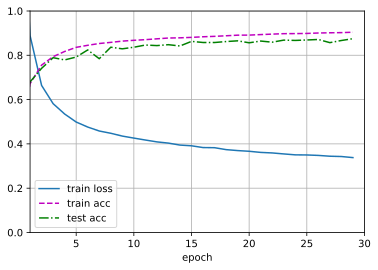

In [ ]:
net = MLP()
model = ModelTrain(net=net, params=net.get_params(), alpha=0.1, solver='sgd', max_iter=30, loss='cross_entropy', lambd=0.0)
model.fit(train_iter, test_iter)